In [1]:
# Makes the display take up more of the screen
from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *

In [5]:
path = untar_data(URLs.PETS)

In [6]:
path.ls()

(#2) [Path('/home/stev/.fastai/data/oxford-iiit-pet/images'),Path('/home/stev/.fastai/data/oxford-iiit-pet/annotations')]

In [8]:
path_im = path/'images'

In [9]:
fname=path_im.ls()[0];fname

Path('/home/stev/.fastai/data/oxford-iiit-pet/images/scottish_terrier_27.jpg')

In [10]:
reg=RegexLabeller(pat = r'/([^/]+)_\d+.*')

In [11]:
sz=(16,16)
bs=24
n_channels=3

In [12]:
btfms = aug_transforms()#+[Normalize.from_stats(*imagenet_stats)]

#Normalize.from_stats(*([0.5]*n_channels,[0.25]*n_channels))]

In [13]:
def x_equals_y(o): return o

In [14]:
block = DataBlock(
    blocks=(ImageBlock, ImageBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(0.2),
    get_y=x_equals_y,
    item_tfms=[Resize(sz, method='squish')],
    batch_tfms=btfms)

In [15]:
dls=block.dataloaders(path_im, batch_size=bs, num_workers=0)

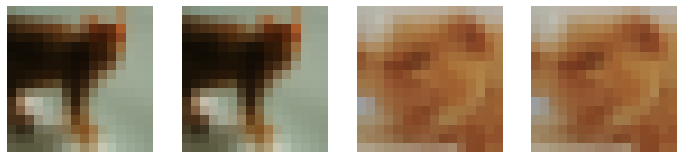

In [16]:
dls.show_batch(max_n=2)

In [17]:
class VAE(nn.Module):
    def __init__(self, hdim=20, channels=3, im_sz=(64,64)):
        """
        Variational Autoencoder that is easily adaptable to different image sizes
        :param size_in: Size of the image in a single dimension. For example: 28 for MNIST
        :param size_emb: Size of the latent space encoding. (default: 5)
        :param enc_siz: The hidden layer sizes for the encoder. Must contain at least one layer.
        :param dec_siz: The hidden layer size for the decoder. Must contain at least one layer.
        :param channels: Number of channels in the in and output. (default: 3)
        """
        super(VAE, self).__init__()        
        
        self.n_conv= 3
        self.channels=channels
        self.im_sz=im_sz
        self.fltn_sz = np.product(np.concatenate([[32],np.array(self.im_sz)-2*self.n_conv]))
        self.mu = None
        self.logvar = None
        self.lin_sz = 128
        
        
        # Encoder layers
        self.enc_conv1 = nn.Conv2d(self.channels, 32, 3)
        self.enc_conv2 = nn.Conv2d(32, 32, 3)
        self.enc_conv3 = nn.Conv2d(32, 32, 3)
        self.enc_fc1 = nn.Linear(self.fltn_sz, self.lin_sz)
        self.enc_fc2_mean = nn.Linear(self.lin_sz, hdim)
        self.enc_fc2_logvar = nn.Linear(self.lin_sz, hdim)

        # Decoder layers
        self.dec_fc1 = nn.Linear(hdim, self.lin_sz)
        self.dec_fc2 = nn.Linear(self.lin_sz, self.fltn_sz)
        unflt_sz0=self.im_sz[0]-2*self.n_conv
        unflt_sz1=self.im_sz[1]-2*self.n_conv
        
        self.dec_unflatten = nn.Unflatten(dim=-1, unflattened_size=(32,unflt_sz0,unflt_sz1))
        self.dec_conv1 = nn.ConvTranspose2d(32, 32, 3)
        self.dec_conv2 = nn.ConvTranspose2d(32, 32, 3)
        self.dec_conv3 = nn.ConvTranspose2d(32, self.channels, 3)
        

    def encode(self, x):
        x = self.enc_conv1((x-0.5)/0.5)
        x = F.relu(x)
        x = self.enc_conv2(x)
        x = F.relu(x)
        x = self.enc_conv3(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.enc_fc1(x)
        x = F.relu(x)
        mean = self.enc_fc2_mean(x)
        logvar = self.enc_fc2_logvar(x)
        return mean, logvar

    @staticmethod
    def reparameterize(mu, logvar):
        std = torch.exp(0.5*logvar) # refactored std = torch.sqrt(torch.exp(logvar))
        eps = torch.randn_like(std) # This isn't dependant on mean or logvar
        return mu + eps * std # So we can trace gradients back through this operation

    def decode(self, x):
        x = self.dec_fc1(x)
        x = F.relu(x)
        x = self.dec_fc2(x)
        x = F.relu(x)
        x = self.dec_unflatten(x)
        x = self.dec_conv1(x)
        x = F.relu(x)
        x = self.dec_conv2(x)
        x = F.relu(x)
        x = self.dec_conv3(x)
        x = torch.sigmoid(x)
        return x #* 6.-3.
    

    def forward(self, x, return_dist = False):
        mean, logvar = self.encode(x) # Predict a distribution
        z = self.reparameterize(mean, logvar) # Sample from it
        self.mu = mean
        self.logvar = logvar        
        if return_dist: return self.decode(z), mean, logvar         
        return self.decode(z)


    def vae_loss_function(self, pred, target):
        """Reconstruction Error + KL divergence losses summed over all elements and batch"""
        BCE = F.binary_cross_entropy(pred, target, reduction='sum')
        KLD = -0.5 * torch.sum(1 + self.logvar - self.mu.pow(2) - self.logvar.exp())
        return BCE + KLD

In [18]:
vae = VAE(hdim=20, channels=n_channels, im_sz=sz)

In [19]:
opt_func = partial(Adam, eps=1e-5)

In [20]:
learn = Learner(dls,vae,
                 opt_func=opt_func,
                 loss_func=vae.vae_loss_function) #

In [21]:
learn.summary()

VAE (Input shape: 24 x 3 x 16 x 16)
Layer (type)         Output Shape         Param #    Trainable 
                     24 x 32 x 14 x 14   
Conv2d                                    896        True      
____________________________________________________________________________
                     24 x 32 x 12 x 12   
Conv2d                                    9248       True      
____________________________________________________________________________
                     24 x 32 x 10 x 10   
Conv2d                                    9248       True      
____________________________________________________________________________
                     24 x 128            
Linear                                    409728     True      
____________________________________________________________________________
                     24 x 20             
Linear                                    2580       True      
Linear                                    2580       True     

SuggestedLRs(valley=0.004365158267319202, slide=6.309573450380412e-07)

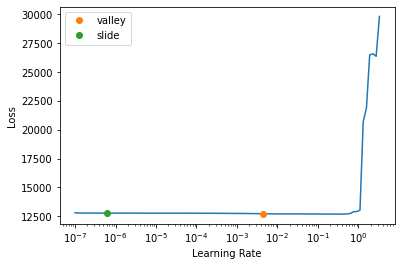

In [22]:
learn.lr_find(suggest_funcs=(valley, slide))

In [23]:
lr=0.01
learn.fit_one_cycle(15, lr_max=lr)

epoch,train_loss,valid_loss,time
0,12037.268555,11830.051758,01:02
1,11716.977539,11605.492188,00:59
2,11656.057617,11609.421875,00:59
3,11615.532227,11574.625000,00:59
4,11612.385742,11601.592773,00:59
5,11576.591797,11470.943359,00:59
6,11566.827148,11484.622070,00:59
7,11517.948242,11439.761719,00:59
8,11493.441406,11440.118164,00:59
9,11455.741211,11418.449219,00:59


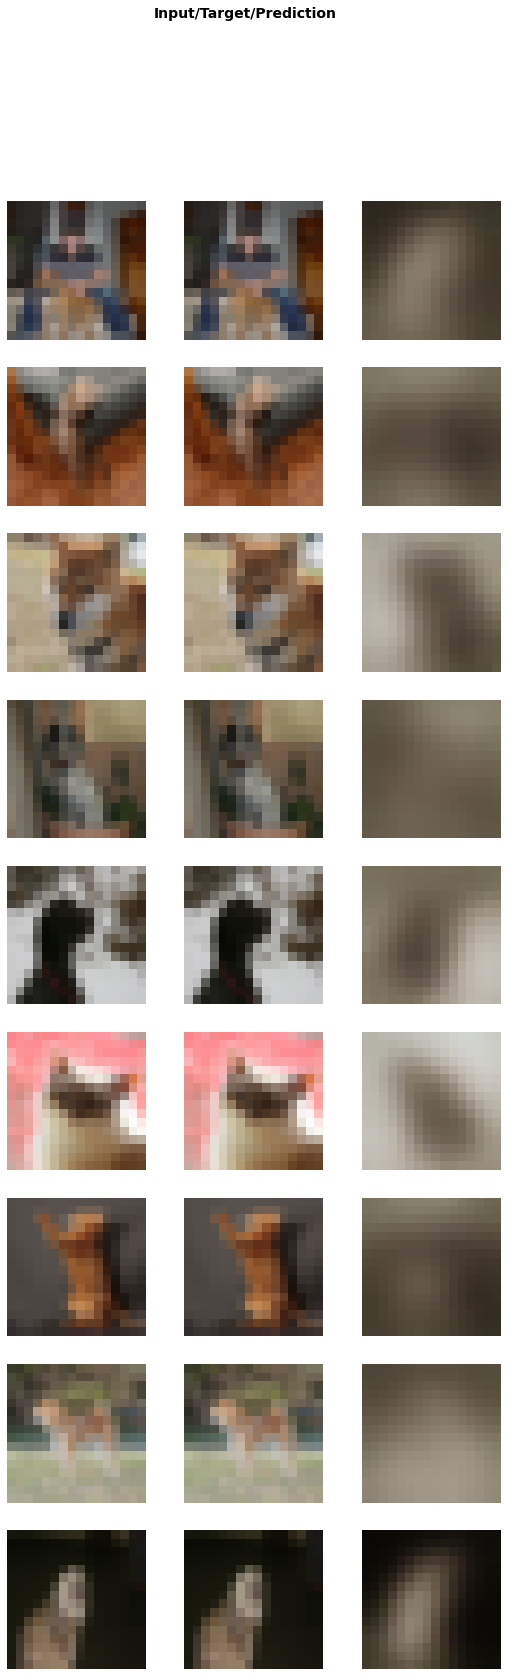

In [24]:
learn.show_results()

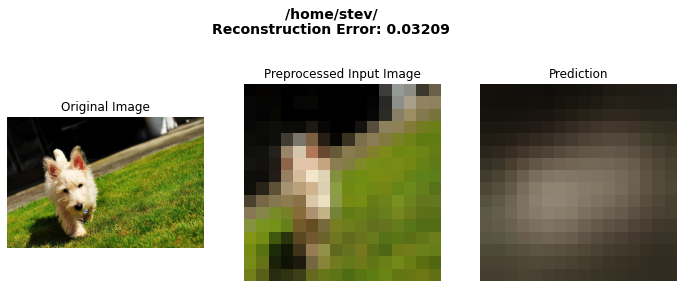

In [25]:
im=PILImage.create(fname)
x_in, clss, idx, prob =learn.predict(im, with_input=True)
mse = MSELossFlat()

#PLOTTING
fig,ax = subplots(1, 3, figsize=(12,7))
ax[0].imshow(np.array(im))
ax[1].imshow(np.transpose(x_in, axes=(1,2,0)))
ax[2].imshow(np.transpose(clss, axes=(1,2,0)))

for i, dscrip in enumerate(['Original Image',
                            'Preprocessed Input Image', 
                            'Prediction']):    

    ax[i].set_title(f'{dscrip}')
    ax[i].set_xticks([]) 
    ax[i].set_yticks([]) 
    ax[i].axis('off')
fl=str(fname).split("\\")[-1].split('.')[0]
fig.suptitle(f'{fl}\nReconstruction Error: {float(mse(clss/255, x_in/255)):.5f}',y=0.85,  weight='bold', size=14)
plt.show()

In [26]:
int2float=IntToFloatTensor()
mean, logvar=vae.encode(to_device(int2float.encodes(x_in))[None,:]) #convert int to float, add dim so shape is (1,3,16,16), and put on GPU

In [27]:
z=vae.reparameterize(mean, logvar)

In [28]:
mean = mean.cpu().detach().numpy().squeeze()
std = torch.exp(0.5*logvar).cpu().detach().numpy().squeeze()
z = z.cpu().detach().numpy().squeeze()

In [29]:
pd.DataFrame(np.c_[mean, std, z], columns=['mean','std','z'])

,mean,std,z
0,-0.023101,1.006613,0.445674
1,-0.353257,0.229952,-0.597072
2,-0.010023,0.998934,0.222565
3,0.506457,0.277706,0.695470
4,-0.582715,0.483287,-0.881697
5,-0.027923,0.990582,-0.540568
6,-0.000303,0.996724,0.037122
7,-0.057521,0.995744,-0.305425
8,-0.337349,0.317423,-0.687192
9,-1.766562,0.438383,-1.786851


In [30]:
target= torch.rand((4,3,32,32))
pred= target-0.01

In [31]:
vae.vae_loss_function(torch.sigmoid(pred), torch.sigmoid(target))

tensor(8044.0947, device='cuda:0')

In [36]:
import datetime as dt
end=dt.datetime.now()
print(f'Finished: {end.strftime("%A %B %d, %Y")} at {end.strftime("%H:%M")}')

Finished: Wednesday January 18, 2023 at 18:19
